<a href="https://colab.research.google.com/github/abasse-dabere/inf554-extractive-summarization-2023/blob/master/HW01_tumor_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

In [ ]:
!pip install --quiet --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import HW01
data_train = HW01.PCAM(root = "/content", split = "val", download = "False")
data_test = HW01.PCAM(root = "/content", split = "test", download = "False")

  Preparing metadata (setup.py) ... done


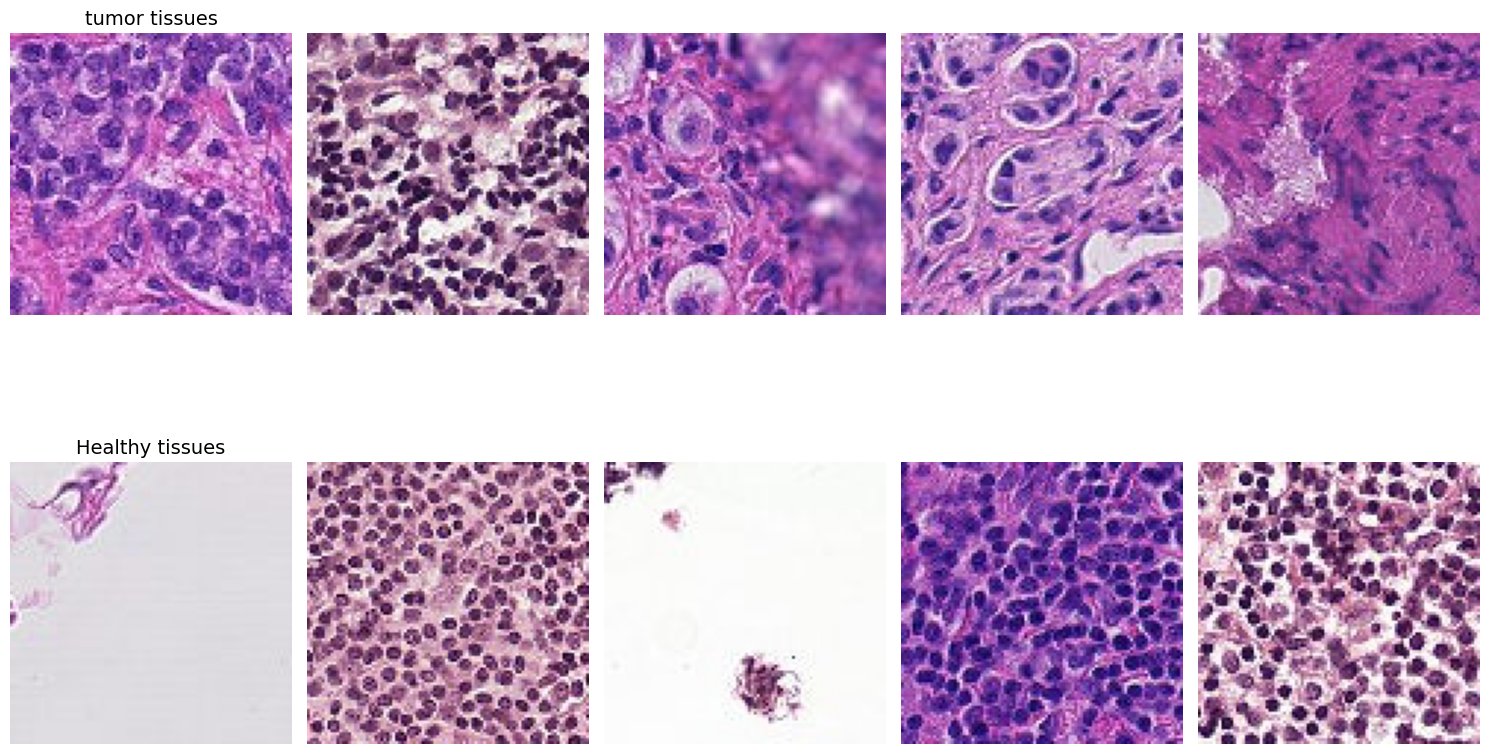

In [ ]:
n = 10
count_pos = 0
count_neg = 0
i = 0
fig, axs = plt.subplots(2, 5, figsize=(15, 10))
while count_pos<5:
  if data_train[i][1] == 1:
    axs[0, count_pos].imshow(data_train[i][0])
    axs[0, count_pos].axis('off')
    count_pos+=1
  i+=1
i = 0


while count_neg<5:
  if data_train[i][1] == 0:
    axs[1, count_neg].imshow(data_train[i][0])
    axs[1, count_neg].axis('off')
    count_neg+=1
  i+=1

# Set titles for each cluster
axs[0, 0].set_title('tumor tissues', fontsize=14)
axs[1, 0].set_title('Healthy tissues', fontsize=14)

plt.tight_layout()
plt.show()

The differences between tumor tissues and healthy ones are difficult to estimate.
There are no clear distinguishable features to take a clear decision from bare eyes.

Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [ ]:
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

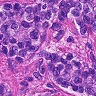

In [ ]:
data_train[0][0]

In [ ]:
data_train.transform = transform_pipeline
data_test.transform = transform_pipeline

In [ ]:
data_train[0][0]

tensor([[[ 1.7180,  1.9749,  1.8208,  ...,  0.4851,  1.7180,  1.5125],
         [ 0.9132,  1.1015,  0.9132,  ...,  1.5639,  1.7180,  1.5639],
         [ 1.4440,  1.2043,  0.8447,  ...,  0.8961,  1.3584,  1.4954],
         ...,
         [-0.6109, -0.5082,  0.2282,  ...,  0.5878, -0.2342, -0.0801],
         [ 0.5364,  0.1426, -0.6623,  ..., -0.0458, -0.4568,  0.0569],
         [ 0.4679,  0.1254, -0.1486,  ...,  0.7248, -0.0287, -0.7308]],

        [[-0.0924,  0.2402,  0.1877,  ..., -0.6001,  0.5378,  0.2577],
         [-0.9328, -0.6702, -0.7577,  ...,  0.5028,  0.5378,  0.3277],
         [-0.3025, -0.5126, -0.8102,  ..., -0.1975,  0.2052,  0.2927],
         ...,
         [-1.4930, -1.3704, -0.6001,  ..., -0.3025, -1.1604, -1.0203],
         [-0.3725, -0.7227, -1.5280,  ..., -0.9328, -1.3704, -0.8452],
         [-0.4601, -0.7752, -1.0378,  ..., -0.1450, -0.9153, -1.5980]],

        [[ 1.5245,  1.8383,  1.7860,  ...,  1.1585,  2.1171,  1.6814],
         [ 0.8099,  1.0539,  0.9494,  ...,  2

In [ ]:
print("the shape of the train set data is: ",data_train[0][0].shape)
print("the shape of the test set data: ",data_test[0][0].shape)

the shape of the train set data is:  torch.Size([3, 96, 96])
the shape of the test set data:  torch.Size([3, 96, 96])


In [ ]:
print("the length of the train set is: ",len(data_train))
print("the length of the test set is: ",len(data_test))

the length of the train set is:  32768
the length of the test set is:  32768


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [ ]:
from torch.utils.data import DataLoader
# Create DataLoaders
train_loader = DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = DataLoader(data_test, batch_size=64)

# Calculate the number of mini-batches for train and test sets
num_train_mini_batches = len(train_loader)
num_test_mini_batches = len(test_loader)

print("Number of mini-batches in train/test set:", num_train_mini_batches)

Number of mini-batches in train/test set: 512


## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [ ]:
# Define the training function
def train(model, dataloader, epochs):

    # Move the model to the correct device
    model.to(device)
    # Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Initialize lists to monitor loss and accuracy
    train_losses = []
    train_accuracies = []
    # Loop over the epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        # Loop over the batches of data in the dataloader
        for batch_idx, (data, target) in enumerate(dataloader):
            # Move the input and target data to the correct device
            data, target = data.to(device), target.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Update running training loss
            running_loss += loss.item() * data.size(0)
            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
        # Calculate average losses and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = 100. * correct / total
        # Append to lists
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch: {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.show()

Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [ ]:
#
# YOUR CODE HERE
def test(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    n_test = len(data_test)
    model.to(device)
    model.eval()
    running_loss, running_acc = 0., 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item()
            running_acc += torch.sum(preds == targets)
    print(f"[TEST] Loss: {running_loss/n_test:.2f} Acc: {100 * running_acc/n_test:.2f}%")

In [ ]:
data_train[0][0].shape

torch.Size([3, 96, 96])

## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

In [ ]:
#Linear model for classification
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*96*96, 2)
)


Epoch: 1/2 - Loss: 1.8957, Accuracy: 58.25%
Epoch: 2/2 - Loss: 1.2200, Accuracy: 63.69%


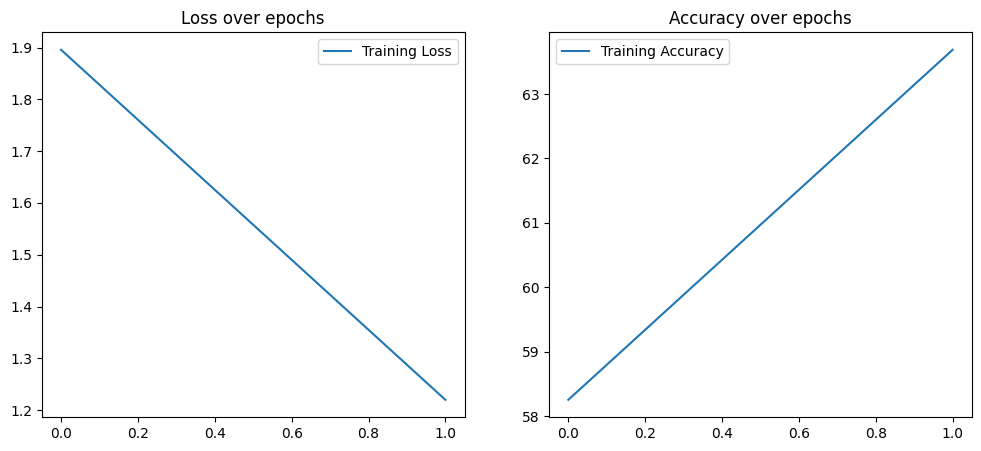

CPU times: user 1min 33s, sys: 13.5 s, total: 1min 47s
Wall time: 1min 49s


In [ ]:
%%time
epochs = 2
train(model, train_loader, epochs)

In [ ]:
%%time
test(model, test_loader)

[TEST] Loss: 0.02 Acc: 58.76%
CPU times: user 46.1 s, sys: 5.18 s, total: 51.3 s
Wall time: 51.8 s


## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [ ]:
# Load the pretrained VGG16 model
vgg16 = models.vgg16(weights='DEFAULT')
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [ ]:
for param in vgg16.parameters():
    param.requires_grad = False

# Replace the last layer (classifier) of the VGG model with a new one
# Number of input features to the classifier is the same as in the original last layer
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)  # 2 outputs for binary classification

# Now only the parameters of the last layer will be updated during training
vgg16.classifier[6].requires_grad = True

Now fine-tune the model by performing 2 epochs of training.

Epoch: 1/2 - Loss: 0.4772, Accuracy: 77.39%
Epoch: 2/2 - Loss: 0.4637, Accuracy: 78.80%


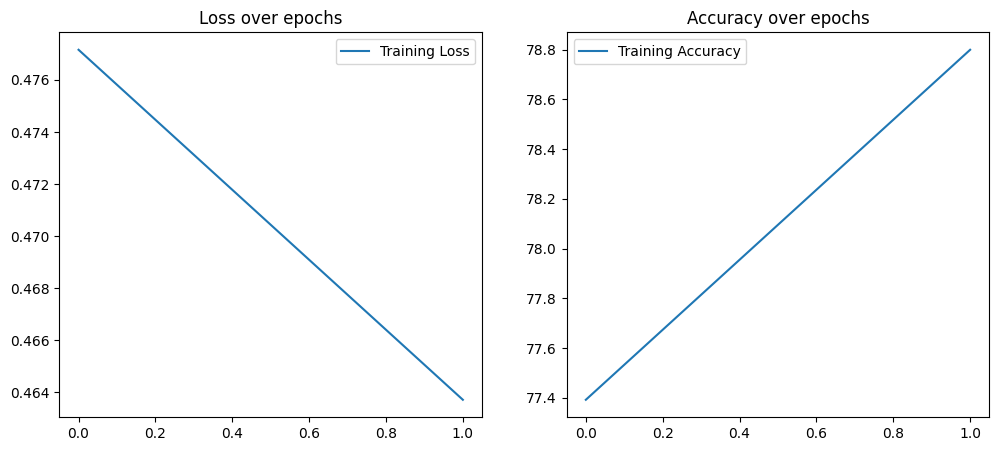

CPU times: user 2min 28s, sys: 13.4 s, total: 2min 41s
Wall time: 2min 42s


In [ ]:
%%time
train(vgg16, train_loader, 2)

In [ ]:
%%time
test(vgg16, test_loader)

[TEST] Loss: 0.01 Acc: 77.81%
CPU times: user 1min 13s, sys: 5.23 s, total: 1min 18s
Wall time: 1min 18s


## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [ ]:
from torch.utils.data import TensorDataset
def precompute_model(model, dataloader):
    model.to(device)
    model.eval()

    # Use lists to store the outputs and labels
    precomputed_outputs = []
    labels_list = []

    with torch.no_grad():  # No need to track gradients
        for inputs, labels in dataloader:
            # Forward pass through the model
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Store the outputs and labels
            precomputed_outputs.append(outputs)
            labels_list.append(labels)
    # Concatenate all outputs and labels along the 0th dimension
    precomputed_outputs = torch.cat(precomputed_outputs, dim=0)
    labels_list = torch.cat(labels_list, dim=0)

    # Create a new dataset from the precomputed outputs and the labels
    precomputed_dataset = TensorDataset(precomputed_outputs, labels_list)

    return precomputed_dataset

Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [ ]:
# Use the features part of the VGG model
model_features = vgg16.features

In [ ]:
#precomputing train dataset
precomputed_dataset = precompute_model(model_features, train_loader)
train_loader_precomputed = DataLoader(precomputed_dataset, batch_size=64, shuffle=True)

In [ ]:
#precomputing test dataset
precomputed_dataset_test = precompute_model(model_features, test_loader)
test_loader_precomputed = DataLoader(precomputed_dataset_test, batch_size=64, shuffle=True)

In [ ]:
### Shape of our new train dataset
precomputed_dataset[0][0].shape

torch.Size([512, 3, 3])

Finally, train a linear model on the our new precomputed features for 50 epochs. Is the model better?

In [ ]:
### New model based on the shape of our new dataset
model_with_preprocessing = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512*3*3, 2)
)

Epoch: 1/50 - Loss: 0.3490, Accuracy: 84.62%
Epoch: 2/50 - Loss: 0.2885, Accuracy: 87.87%
Epoch: 3/50 - Loss: 0.2698, Accuracy: 88.65%
Epoch: 4/50 - Loss: 0.2560, Accuracy: 89.29%
Epoch: 5/50 - Loss: 0.2492, Accuracy: 89.52%
Epoch: 6/50 - Loss: 0.2405, Accuracy: 90.19%
Epoch: 7/50 - Loss: 0.2449, Accuracy: 89.92%
Epoch: 8/50 - Loss: 0.2318, Accuracy: 90.29%
Epoch: 9/50 - Loss: 0.2307, Accuracy: 90.45%
Epoch: 10/50 - Loss: 0.2227, Accuracy: 90.81%
Epoch: 11/50 - Loss: 0.2209, Accuracy: 90.71%
Epoch: 12/50 - Loss: 0.2188, Accuracy: 91.00%
Epoch: 13/50 - Loss: 0.2188, Accuracy: 91.12%
Epoch: 14/50 - Loss: 0.2145, Accuracy: 91.30%
Epoch: 15/50 - Loss: 0.2133, Accuracy: 91.31%
Epoch: 16/50 - Loss: 0.2093, Accuracy: 91.52%
Epoch: 17/50 - Loss: 0.2112, Accuracy: 91.36%
Epoch: 18/50 - Loss: 0.2149, Accuracy: 91.24%
Epoch: 19/50 - Loss: 0.2151, Accuracy: 91.20%
Epoch: 20/50 - Loss: 0.2061, Accuracy: 91.53%
Epoch: 21/50 - Loss: 0.2079, Accuracy: 91.47%
Epoch: 22/50 - Loss: 0.2029, Accuracy: 91.8

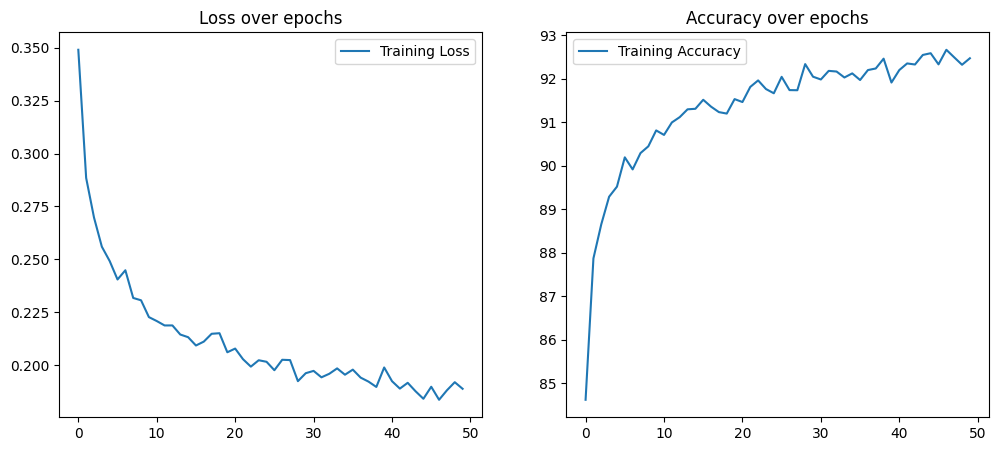

CPU times: user 41.8 s, sys: 1.18 s, total: 43 s
Wall time: 43.7 s


In [ ]:
%%time
train(model_with_preprocessing,train_loader_precomputed, 50)

In [ ]:
test(model_with_preprocessing, test_loader_precomputed)

[TEST] Loss: 0.03 Acc: 71.33%


The new model is more efficient with a better overall accuracy and much less time consuming even with 25 times more epochs.